# READ

1. API is in User Variables for User in Environemtn Variables named "NEPTUNE_API_TOKEN"
2. If internet sucks, set mode to offline
4. When offline runs are saved locally, sync it with | neptune sync -p "New-Thesis/KFold-Test" --offline-only |
- make sure it is in venv mode | (venv) PS C:\Users\user\Documents\Machine-Learning-Hub-1\ImageClassification\Neptune-Thesis> |
5. Delete the offline folder or use | neptune clear |

# Load Libraries

In [1]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

# Initialize Functions

In [2]:
model_name = "V4.1.1"
checkpoint_path = f'./checkpoints/{model_name}/FOLD-'

In [16]:
def make_model(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))
    
    model.add(Conv2D(input_shape=(256,256,3), filters=32, kernel_size=(3,3), padding="same"))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=128,activation="relu"))
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=128,activation="relu"))
    
    model.add(Dense(units=4, activation="softmax"))


    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )
    
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
def create_callbacks(counter):
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + str(counter), 
                                                                 monitor='val_loss', 
                                                                 mode='auto', 
                                                                 save_best_only=True, 
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience=23,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                         factor=0.6, 
                                                         patience=10, 
                                                         min_delta=0.001, 
                                                         mode='auto', 
                                                         verbose=1)
    return [neptune_cbk, reduce_lr, cp_callback, es_callback]

In [5]:
def plot_loss(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

In [6]:
def plot_acc(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

In [7]:
def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

# Prepare Dataset

In [8]:
labels = ['Building', 'Plant', 'Road', 'Vehicle']
X_train = []
y_train = []
y_label_idx = []
image_size = 256
for i in labels:
    folderPath = os.path.join('D:\DATASETS\For-Thesis\Labels', i)
    for j in os.listdir(folderPath):
        img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_label_idx.append(labels.index(i))

In [9]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0

In [10]:
rng = default_rng(seed=1)

buildings_test_idx = rng.choice(np.arange(0,600), size=120, replace=False)
plants_test_idx = rng.choice(np.arange(600,1200), size=120, replace=False)
roads_test_idx = rng.choice(np.arange(1200,1800), size=120, replace=False)
vehicles_test_idx = rng.choice(np.arange(1800,2400), size=120, replace=False)
total_test_idx = np.concatenate((buildings_test_idx, plants_test_idx, roads_test_idx, vehicles_test_idx), axis=None)

In [11]:
def train_test_X(X_train_scaled):    
    test_x = X_train_scaled[total_test_idx]
    train_x = np.delete(X_train_scaled, total_test_idx, axis=0)
    return train_x, test_x

def train_test_y(y_label_idx):
    test_y = y_label_idx[total_test_idx]
    train_y = np.delete(y_label_idx, total_test_idx, axis=0)
    return train_y, test_y

In [12]:
train_x, holdout_x = train_test_X(X_train_scaled)
train_y, holdout_y = train_test_y(y_label_idx)

In [13]:
print(len(train_x), len(holdout_x))

1920 480


In [14]:
print(train_y[:5])

[0 0 0 0 0]


In [15]:
# Inidices remain the same thanks to the seed (set to 1)
# with open('total_test_idx.txt', 'w+') as f:
     
#     # write elements of list
#     for items in total_test_idx:
#         f.write('%s ' %items)
     
#     print("File written successfully")
 
 
# # close the file
# f.close()

# Run KFOLD

In [17]:
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)

In [18]:
project_name = "New-Thesis/KFold-Test"
# api_token = <It is already initialized in environemnt variables>
params = {
    "lr": 0.0015, 
    "epochs": 45, 
    "batch_size": 8}

In [19]:
# run.stop()

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: offline/c5d0b559-9fe3-4f79-b441-761d793791ac


Epoch 1/45


210/210 [==============================] - ETA: 0s - loss: 12.2210 - accuracy: 0.3536
Epoch 1: val_loss improved from inf to 2.47975, saving model to ./checkpoints/V4.1.1\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-0\assets


210/210 [==============================] - 372s 2s/step - loss: 12.2210 - accuracy: 0.3536 - val_loss: 2.4798 - val_accuracy: 0.3792 - lr: 0.0015
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.3860 - accuracy: 0.2589
Epoch 2: val_loss improved from 2.47975 to 1.37829, saving model to ./checkpoints/V4.1.1\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-0\assets


210/210 [==============================] - 380s 2s/step - loss: 1.3860 - accuracy: 0.2589 - val_loss: 1.3783 - val_accuracy: 0.2708 - lr: 0.0015
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 1.3359 - accuracy: 0.3470
Epoch 3: val_loss improved from 1.37829 to 1.25273, saving model to ./checkpoints/V4.1.1\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-0\assets


210/210 [==============================] - 377s 2s/step - loss: 1.3359 - accuracy: 0.3470 - val_loss: 1.2527 - val_accuracy: 0.4042 - lr: 0.0015
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 1.3143 - accuracy: 0.3786
Epoch 4: val_loss did not improve from 1.25273
210/210 [==============================] - 326s 2s/step - loss: 1.3143 - accuracy: 0.3786 - val_loss: 1.3057 - val_accuracy: 0.4000 - lr: 0.0015
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 1.3432 - accuracy: 0.3619
Epoch 5: val_loss did not improve from 1.25273
210/210 [==============================] - 315s 1s/step - loss: 1.3432 - accuracy: 0.3619 - val_loss: 1.3458 - val_accuracy: 0.3667 - lr: 0.0015
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 1.3940 - accuracy: 0.2536
Epoch 6: val_loss did not improve from 1.25273
210/210 [==============================] - 327s 2s/step - loss: 1.3940 - accuracy: 0.2536 - val_loss: 1.3829 - val_accuracy: 0.2625 - lr

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-0\assets


210/210 [==============================] - 314s 1s/step - loss: 1.3239 - accuracy: 0.3548 - val_loss: 1.1744 - val_accuracy: 0.5250 - lr: 0.0015
Epoch 10/45
210/210 [==============================] - ETA: 0s - loss: 1.3729 - accuracy: 0.2905
Epoch 10: val_loss did not improve from 1.17439
210/210 [==============================] - 306s 1s/step - loss: 1.3729 - accuracy: 0.2905 - val_loss: 1.3811 - val_accuracy: 0.2625 - lr: 0.0015
Epoch 11/45
210/210 [==============================] - ETA: 0s - loss: 1.3883 - accuracy: 0.2720
Epoch 11: val_loss did not improve from 1.17439
210/210 [==============================] - 305s 1s/step - loss: 1.3883 - accuracy: 0.2720 - val_loss: 1.3822 - val_accuracy: 0.2667 - lr: 0.0015
Epoch 12/45
210/210 [==============================] - ETA: 0s - loss: 1.3772 - accuracy: 0.2619
Epoch 12: val_loss did not improve from 1.17439
210/210 [==============================] - 304s 1s/step - loss: 1.3772 - accuracy: 0.2619 - val_loss: 1.3928 - val_accuracy: 0.416

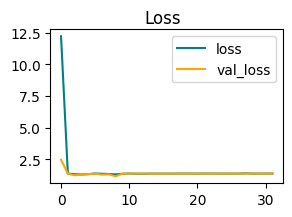

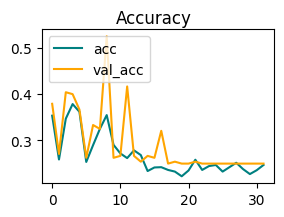

Fold Training Time: 2 hour(s) and 47 mins
Precision: 57.999998331069946  -  Recall: 12.083332985639572
Accuracy: 52.49999761581421
F1Score: Building 39.17525863647461 | Plant 3.278688669204712 | Road 69.8795166015625 | Vehicle 61.5384635925293
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/3ec2a709-55bb-4111-b384-97e57f52bb42
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 9.9445 - accuracy: 0.4042
Epoch 1: val_loss improved from inf to 1.38300, saving model to ./checkpoints/V4.1.1\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-1\assets


210/210 [==============================] - 315s 1s/step - loss: 9.9445 - accuracy: 0.4042 - val_loss: 1.3830 - val_accuracy: 0.2542 - lr: 0.0015
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.2699 - accuracy: 0.3905
Epoch 2: val_loss improved from 1.38300 to 1.29626, saving model to ./checkpoints/V4.1.1\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-1\assets


210/210 [==============================] - 307s 1s/step - loss: 1.2699 - accuracy: 0.3905 - val_loss: 1.2963 - val_accuracy: 0.3375 - lr: 0.0015
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 1.2451 - accuracy: 0.4131
Epoch 3: val_loss did not improve from 1.29626
210/210 [==============================] - 301s 1s/step - loss: 1.2451 - accuracy: 0.4131 - val_loss: 2.0747 - val_accuracy: 0.2958 - lr: 0.0015
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 1.2101 - accuracy: 0.4226
Epoch 4: val_loss did not improve from 1.29626
210/210 [==============================] - 300s 1s/step - loss: 1.2101 - accuracy: 0.4226 - val_loss: 1.3835 - val_accuracy: 0.3958 - lr: 0.0015
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 1.1953 - accuracy: 0.4048
Epoch 5: val_loss did not improve from 1.29626
210/210 [==============================] - 300s 1s/step - loss: 1.1953 - accuracy: 0.4048 - val_loss: 1.4346 - val_accuracy: 0.2667 - lr

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-1\assets


210/210 [==============================] - 306s 1s/step - loss: 1.2278 - accuracy: 0.3750 - val_loss: 1.1322 - val_accuracy: 0.4125 - lr: 0.0015
Epoch 10/45
210/210 [==============================] - ETA: 0s - loss: 1.2429 - accuracy: 0.3833
Epoch 10: val_loss did not improve from 1.13220
210/210 [==============================] - 301s 1s/step - loss: 1.2429 - accuracy: 0.3833 - val_loss: 1.2130 - val_accuracy: 0.3708 - lr: 0.0015
Epoch 11/45
210/210 [==============================] - ETA: 0s - loss: 1.2399 - accuracy: 0.3964
Epoch 11: val_loss improved from 1.13220 to 1.00756, saving model to ./checkpoints/V4.1.1\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-1\assets


210/210 [==============================] - 308s 1s/step - loss: 1.2399 - accuracy: 0.3964 - val_loss: 1.0076 - val_accuracy: 0.4792 - lr: 0.0015
Epoch 12/45
210/210 [==============================] - ETA: 0s - loss: 1.1544 - accuracy: 0.4179
Epoch 12: val_loss did not improve from 1.00756
210/210 [==============================] - 304s 1s/step - loss: 1.1544 - accuracy: 0.4179 - val_loss: 1.3255 - val_accuracy: 0.3292 - lr: 0.0015
Epoch 13/45
210/210 [==============================] - ETA: 0s - loss: 1.2313 - accuracy: 0.3863
Epoch 13: val_loss did not improve from 1.00756
210/210 [==============================] - 311s 1s/step - loss: 1.2313 - accuracy: 0.3863 - val_loss: 2.5909 - val_accuracy: 0.3375 - lr: 0.0015
Epoch 14/45
210/210 [==============================] - ETA: 0s - loss: 1.1976 - accuracy: 0.3994
Epoch 14: val_loss did not improve from 1.00756
210/210 [==============================] - 310s 1s/step - loss: 1.1976 - accuracy: 0.3994 - val_loss: 1.3673 - val_accuracy: 0.437

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-1\assets


210/210 [==============================] - 307s 1s/step - loss: 1.0453 - accuracy: 0.4500 - val_loss: 1.0021 - val_accuracy: 0.4750 - lr: 5.4000e-04
Epoch 35/45
210/210 [==============================] - ETA: 0s - loss: 1.0371 - accuracy: 0.4661
Epoch 35: val_loss did not improve from 1.00207
210/210 [==============================] - 299s 1s/step - loss: 1.0371 - accuracy: 0.4661 - val_loss: 1.2234 - val_accuracy: 0.4625 - lr: 5.4000e-04
Epoch 36/45
210/210 [==============================] - ETA: 0s - loss: 1.0053 - accuracy: 0.4625
Epoch 36: val_loss did not improve from 1.00207
210/210 [==============================] - 299s 1s/step - loss: 1.0053 - accuracy: 0.4625 - val_loss: 1.2397 - val_accuracy: 0.4458 - lr: 5.4000e-04
Epoch 37/45
210/210 [==============================] - ETA: 0s - loss: 1.0238 - accuracy: 0.4548
Epoch 37: val_loss improved from 1.00207 to 0.97755, saving model to ./checkpoints/V4.1.1\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-1\assets

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-1\assets


210/210 [==============================] - 307s 1s/step - loss: 1.0238 - accuracy: 0.4548 - val_loss: 0.9775 - val_accuracy: 0.4667 - lr: 5.4000e-04
Epoch 38/45
210/210 [==============================] - ETA: 0s - loss: 1.0315 - accuracy: 0.4458
Epoch 38: val_loss did not improve from 0.97755
210/210 [==============================] - 300s 1s/step - loss: 1.0315 - accuracy: 0.4458 - val_loss: 5.6571 - val_accuracy: 0.2500 - lr: 5.4000e-04
Epoch 39/45
210/210 [==============================] - ETA: 0s - loss: 1.0537 - accuracy: 0.4488
Epoch 39: val_loss did not improve from 0.97755
210/210 [==============================] - 299s 1s/step - loss: 1.0537 - accuracy: 0.4488 - val_loss: 1.0106 - val_accuracy: 0.4625 - lr: 5.4000e-04
Epoch 40/45
210/210 [==============================] - ETA: 0s - loss: 1.0380 - accuracy: 0.4619
Epoch 40: val_loss did not improve from 0.97755
210/210 [==============================] - 301s 1s/step - loss: 1.0380 - accuracy: 0.4619 - val_loss: 1.0703 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-1\assets


210/210 [==============================] - 307s 1s/step - loss: 1.0355 - accuracy: 0.4274 - val_loss: 0.9765 - val_accuracy: 0.4833 - lr: 5.4000e-04
Epoch 44/45
210/210 [==============================] - ETA: 0s - loss: 1.0265 - accuracy: 0.4518
Epoch 44: val_loss did not improve from 0.97655
210/210 [==============================] - 299s 1s/step - loss: 1.0265 - accuracy: 0.4518 - val_loss: 1.8257 - val_accuracy: 0.2875 - lr: 5.4000e-04
Epoch 45/45
210/210 [==============================] - ETA: 0s - loss: 0.9936 - accuracy: 0.4518
Epoch 45: val_loss did not improve from 0.97655
210/210 [==============================] - 299s 1s/step - loss: 0.9936 - accuracy: 0.4518 - val_loss: 1.0375 - val_accuracy: 0.4667 - lr: 5.4000e-04


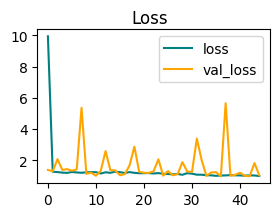

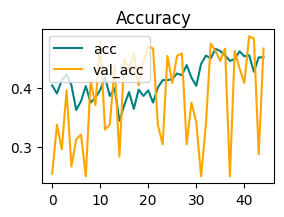

Fold Training Time: 3 hour(s) and 46 mins
Precision: 84.61538553237915  -  Recall: 22.91666716337204
Accuracy: 48.33333194255829
F1Score: Building 6.451613426208496 | Plant 85.92591857910156 | Road 0.0 | Vehicle 50.22421646118164
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/f3c5ce2f-1fc5-4ea9-9f5b-84e490d1b899
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 9.5506 - accuracy: 0.3804
Epoch 1: val_loss improved from inf to 1.68726, saving model to ./checkpoints/V4.1.1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-2\assets


210/210 [==============================] - 315s 1s/step - loss: 9.5506 - accuracy: 0.3804 - val_loss: 1.6873 - val_accuracy: 0.3625 - lr: 0.0015
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.1819 - accuracy: 0.4458
Epoch 2: val_loss improved from 1.68726 to 1.11825, saving model to ./checkpoints/V4.1.1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-2\assets


210/210 [==============================] - 305s 1s/step - loss: 1.1819 - accuracy: 0.4458 - val_loss: 1.1183 - val_accuracy: 0.5292 - lr: 0.0015
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 1.1146 - accuracy: 0.5083
Epoch 3: val_loss improved from 1.11825 to 1.07976, saving model to ./checkpoints/V4.1.1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-2\assets


210/210 [==============================] - 305s 1s/step - loss: 1.1146 - accuracy: 0.5083 - val_loss: 1.0798 - val_accuracy: 0.5583 - lr: 0.0015
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 1.0413 - accuracy: 0.5363
Epoch 4: val_loss improved from 1.07976 to 0.97337, saving model to ./checkpoints/V4.1.1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-2\assets


210/210 [==============================] - 306s 1s/step - loss: 1.0413 - accuracy: 0.5363 - val_loss: 0.9734 - val_accuracy: 0.5792 - lr: 0.0015
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 1.0231 - accuracy: 0.5565
Epoch 5: val_loss did not improve from 0.97337
210/210 [==============================] - 299s 1s/step - loss: 1.0231 - accuracy: 0.5565 - val_loss: 5.2640 - val_accuracy: 0.3250 - lr: 0.0015
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 1.1351 - accuracy: 0.4690
Epoch 6: val_loss did not improve from 0.97337
210/210 [==============================] - 299s 1s/step - loss: 1.1351 - accuracy: 0.4690 - val_loss: 1.3808 - val_accuracy: 0.3083 - lr: 0.0015
Epoch 7/45
210/210 [==============================] - ETA: 0s - loss: 1.0823 - accuracy: 0.5048
Epoch 7: val_loss did not improve from 0.97337
210/210 [==============================] - 299s 1s/step - loss: 1.0823 - accuracy: 0.5048 - val_loss: 1.1006 - val_accuracy: 0.4917 - lr

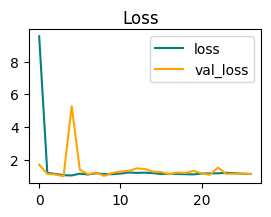

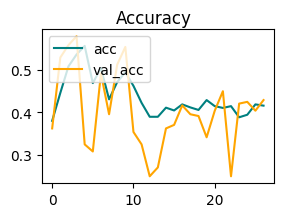

Fold Training Time: 2 hour(s) and 15 mins
Precision: 94.44444179534912  -  Recall: 28.333333134651184
Accuracy: 57.91666507720947
F1Score: Building 9.756097793579102 | Plant 84.95575714111328 | Road 68.81720733642578 | Vehicle 57.291664123535156
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/26393dd7-92b9-46b2-bc49-688c55e052f7
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 9.6296 - accuracy: 0.4512
Epoch 1: val_loss improved from inf to 1.40031, saving model to ./checkpoints/V4.1.1\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-3\assets


210/210 [==============================] - 309s 1s/step - loss: 9.6296 - accuracy: 0.4512 - val_loss: 1.4003 - val_accuracy: 0.2708 - lr: 0.0015
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.0016 - accuracy: 0.5542
Epoch 2: val_loss improved from 1.40031 to 1.16578, saving model to ./checkpoints/V4.1.1\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-3\assets


210/210 [==============================] - 303s 1s/step - loss: 1.0016 - accuracy: 0.5542 - val_loss: 1.1658 - val_accuracy: 0.5000 - lr: 0.0015
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 0.9954 - accuracy: 0.5405
Epoch 3: val_loss improved from 1.16578 to 0.92447, saving model to ./checkpoints/V4.1.1\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-3\assets


210/210 [==============================] - 303s 1s/step - loss: 0.9954 - accuracy: 0.5405 - val_loss: 0.9245 - val_accuracy: 0.6375 - lr: 0.0015
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 1.0014 - accuracy: 0.5756
Epoch 4: val_loss did not improve from 0.92447
210/210 [==============================] - 297s 1s/step - loss: 1.0014 - accuracy: 0.5756 - val_loss: 1.1659 - val_accuracy: 0.5000 - lr: 0.0015
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 1.0447 - accuracy: 0.5560
Epoch 5: val_loss did not improve from 0.92447
210/210 [==============================] - 298s 1s/step - loss: 1.0447 - accuracy: 0.5560 - val_loss: 0.9413 - val_accuracy: 0.6292 - lr: 0.0015
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 1.0122 - accuracy: 0.5631
Epoch 6: val_loss did not improve from 0.92447
210/210 [==============================] - 298s 1s/step - loss: 1.0122 - accuracy: 0.5631 - val_loss: 1.1139 - val_accuracy: 0.4583 - lr

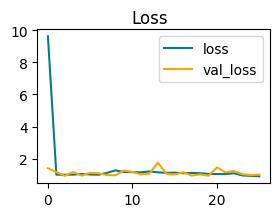

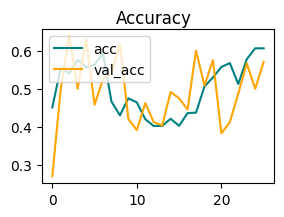

Fold Training Time: 2 hour(s) and 10 mins
Precision: 81.30841255187988  -  Recall: 36.250001192092896
Accuracy: 63.749998807907104
F1Score: Building 56.80473327636719 | Plant 85.27132415771484 | Road 63.91752243041992 | Vehicle 44.70588302612305
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/dcb330fb-e418-47ba-93de-642eb4085efc
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 7.7328 - accuracy: 0.3821
Epoch 1: val_loss improved from inf to 1.38504, saving model to ./checkpoints/V4.1.1\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-4\assets


210/210 [==============================] - 315s 1s/step - loss: 7.7328 - accuracy: 0.3821 - val_loss: 1.3850 - val_accuracy: 0.2625 - lr: 0.0015
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.2215 - accuracy: 0.4202
Epoch 2: val_loss improved from 1.38504 to 1.17378, saving model to ./checkpoints/V4.1.1\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-4\assets


210/210 [==============================] - 310s 1s/step - loss: 1.2215 - accuracy: 0.4202 - val_loss: 1.1738 - val_accuracy: 0.4583 - lr: 0.0015
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 1.2741 - accuracy: 0.3869
Epoch 3: val_loss did not improve from 1.17378
210/210 [==============================] - 307s 1s/step - loss: 1.2741 - accuracy: 0.3869 - val_loss: 1.2149 - val_accuracy: 0.4917 - lr: 0.0015
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 1.2481 - accuracy: 0.3988
Epoch 4: val_loss improved from 1.17378 to 1.08778, saving model to ./checkpoints/V4.1.1\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-4\assets


210/210 [==============================] - 312s 1s/step - loss: 1.2481 - accuracy: 0.3988 - val_loss: 1.0878 - val_accuracy: 0.4625 - lr: 0.0015
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 1.2522 - accuracy: 0.3899
Epoch 5: val_loss did not improve from 1.08778
210/210 [==============================] - 304s 1s/step - loss: 1.2522 - accuracy: 0.3899 - val_loss: 1.2614 - val_accuracy: 0.3917 - lr: 0.0015
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 1.2484 - accuracy: 0.3893
Epoch 6: val_loss did not improve from 1.08778
210/210 [==============================] - 306s 1s/step - loss: 1.2484 - accuracy: 0.3893 - val_loss: 1.2944 - val_accuracy: 0.4375 - lr: 0.0015
Epoch 7/45
210/210 [==============================] - ETA: 0s - loss: 1.3167 - accuracy: 0.3607
Epoch 7: val_loss did not improve from 1.08778
210/210 [==============================] - 304s 1s/step - loss: 1.3167 - accuracy: 0.3607 - val_loss: 1.1551 - val_accuracy: 0.4292 - lr

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-4\assets


210/210 [==============================] - 306s 1s/step - loss: 1.1095 - accuracy: 0.4190 - val_loss: 1.0398 - val_accuracy: 0.4542 - lr: 5.4000e-04
Epoch 28/45
210/210 [==============================] - ETA: 0s - loss: 1.0771 - accuracy: 0.4470
Epoch 28: val_loss did not improve from 1.03977
210/210 [==============================] - 299s 1s/step - loss: 1.0771 - accuracy: 0.4470 - val_loss: 1.0536 - val_accuracy: 0.4750 - lr: 5.4000e-04
Epoch 29/45
210/210 [==============================] - ETA: 0s - loss: 1.0540 - accuracy: 0.4512
Epoch 29: val_loss improved from 1.03977 to 1.00620, saving model to ./checkpoints/V4.1.1\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-4\assets


210/210 [==============================] - 305s 1s/step - loss: 1.0540 - accuracy: 0.4512 - val_loss: 1.0062 - val_accuracy: 0.4708 - lr: 5.4000e-04
Epoch 30/45
210/210 [==============================] - ETA: 0s - loss: 1.0237 - accuracy: 0.4500
Epoch 30: val_loss did not improve from 1.00620
210/210 [==============================] - 299s 1s/step - loss: 1.0237 - accuracy: 0.4500 - val_loss: 1.3157 - val_accuracy: 0.3583 - lr: 5.4000e-04
Epoch 31/45
210/210 [==============================] - ETA: 0s - loss: 1.0253 - accuracy: 0.4839
Epoch 31: val_loss did not improve from 1.00620
210/210 [==============================] - 297s 1s/step - loss: 1.0253 - accuracy: 0.4839 - val_loss: 1.1056 - val_accuracy: 0.4875 - lr: 5.4000e-04
Epoch 32/45
210/210 [==============================] - ETA: 0s - loss: 1.0147 - accuracy: 0.4786
Epoch 32: val_loss did not improve from 1.00620
210/210 [==============================] - 298s 1s/step - loss: 1.0147 - accuracy: 0.4786 - val_loss: 2.8044 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-4\assets


210/210 [==============================] - 304s 1s/step - loss: 0.9957 - accuracy: 0.4690 - val_loss: 0.9994 - val_accuracy: 0.5167 - lr: 5.4000e-04
Epoch 37/45
210/210 [==============================] - ETA: 0s - loss: 1.0404 - accuracy: 0.4595
Epoch 37: val_loss did not improve from 0.99938
210/210 [==============================] - 298s 1s/step - loss: 1.0404 - accuracy: 0.4595 - val_loss: 1.1433 - val_accuracy: 0.4792 - lr: 5.4000e-04
Epoch 38/45
210/210 [==============================] - ETA: 0s - loss: 1.0090 - accuracy: 0.4655
Epoch 38: val_loss did not improve from 0.99938
210/210 [==============================] - 299s 1s/step - loss: 1.0090 - accuracy: 0.4655 - val_loss: 1.2514 - val_accuracy: 0.3958 - lr: 5.4000e-04
Epoch 39/45
210/210 [==============================] - ETA: 0s - loss: 1.0163 - accuracy: 0.4500
Epoch 39: val_loss did not improve from 0.99938
210/210 [==============================] - 298s 1s/step - loss: 1.0163 - accuracy: 0.4500 - val_loss: 1.3672 - val_acc

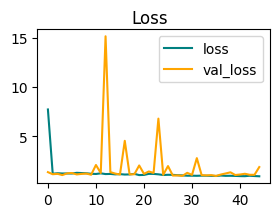

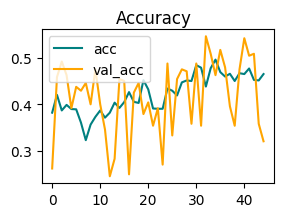

Fold Training Time: 3 hour(s) and 45 mins
Precision: 94.44444179534912  -  Recall: 21.250000596046448
Accuracy: 51.66666507720947
F1Score: Building 29.268295288085938 | Plant 90.5982894897461 | Road 53.39366912841797 | Vehicle 0.0
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/d1ca7493-a25c-46b5-80ae-bcb602afd6da
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 9.5193 - accuracy: 0.4119
Epoch 1: val_loss improved from inf to 2.55752, saving model to ./checkpoints/V4.1.1\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-5\assets


210/210 [==============================] - 307s 1s/step - loss: 9.5193 - accuracy: 0.4119 - val_loss: 2.5575 - val_accuracy: 0.3583 - lr: 0.0015
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.1551 - accuracy: 0.4655
Epoch 2: val_loss improved from 2.55752 to 0.98796, saving model to ./checkpoints/V4.1.1\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-5\assets


210/210 [==============================] - 304s 1s/step - loss: 1.1551 - accuracy: 0.4655 - val_loss: 0.9880 - val_accuracy: 0.5750 - lr: 0.0015
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 1.0551 - accuracy: 0.5256
Epoch 3: val_loss did not improve from 0.98796
210/210 [==============================] - 295s 1s/step - loss: 1.0551 - accuracy: 0.5256 - val_loss: 1.0736 - val_accuracy: 0.5083 - lr: 0.0015
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 1.0424 - accuracy: 0.5292
Epoch 4: val_loss improved from 0.98796 to 0.88823, saving model to ./checkpoints/V4.1.1\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-5\assets


210/210 [==============================] - 302s 1s/step - loss: 1.0424 - accuracy: 0.5292 - val_loss: 0.8882 - val_accuracy: 0.5875 - lr: 0.0015
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 1.0416 - accuracy: 0.5226
Epoch 5: val_loss did not improve from 0.88823
210/210 [==============================] - 301s 1s/step - loss: 1.0416 - accuracy: 0.5226 - val_loss: 0.9244 - val_accuracy: 0.5750 - lr: 0.0015
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 1.1054 - accuracy: 0.4839
Epoch 6: val_loss did not improve from 0.88823
210/210 [==============================] - 298s 1s/step - loss: 1.1054 - accuracy: 0.4839 - val_loss: 0.9100 - val_accuracy: 0.5750 - lr: 0.0015
Epoch 7/45
210/210 [==============================] - ETA: 0s - loss: 1.1621 - accuracy: 0.4589
Epoch 7: val_loss did not improve from 0.88823
210/210 [==============================] - 300s 1s/step - loss: 1.1621 - accuracy: 0.4589 - val_loss: 17.6833 - val_accuracy: 0.2500 - l

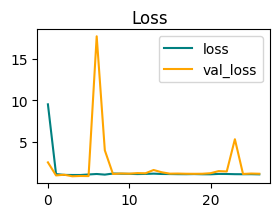

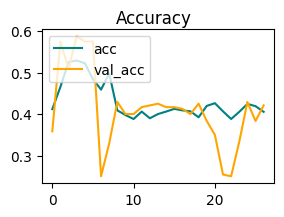

Fold Training Time: 2 hour(s) and 15 mins
Precision: 94.04761791229248  -  Recall: 32.91666805744171
Accuracy: 58.74999761581421
F1Score: Building 0.0 | Plant 88.0 | Road 63.73626708984375 | Vehicle 57.57575607299805
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/982fc7e7-5bef-46b3-b5f6-15a63d26863a
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 10.9743 - accuracy: 0.4696
Epoch 1: val_loss improved from inf to 1.23634, saving model to ./checkpoints/V4.1.1\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-6\assets


210/210 [==============================] - 326s 2s/step - loss: 10.9743 - accuracy: 0.4696 - val_loss: 1.2363 - val_accuracy: 0.4708 - lr: 0.0015
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.1220 - accuracy: 0.4857
Epoch 2: val_loss improved from 1.23634 to 1.18755, saving model to ./checkpoints/V4.1.1\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-6\assets


210/210 [==============================] - 320s 2s/step - loss: 1.1220 - accuracy: 0.4857 - val_loss: 1.1875 - val_accuracy: 0.4042 - lr: 0.0015
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 1.1903 - accuracy: 0.4101
Epoch 3: val_loss improved from 1.18755 to 1.01897, saving model to ./checkpoints/V4.1.1\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-6\assets


210/210 [==============================] - 304s 1s/step - loss: 1.1903 - accuracy: 0.4101 - val_loss: 1.0190 - val_accuracy: 0.5792 - lr: 0.0015
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 1.1095 - accuracy: 0.4780
Epoch 4: val_loss did not improve from 1.01897
210/210 [==============================] - 296s 1s/step - loss: 1.1095 - accuracy: 0.4780 - val_loss: 1.0391 - val_accuracy: 0.6125 - lr: 0.0015
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 1.1476 - accuracy: 0.4643
Epoch 5: val_loss did not improve from 1.01897
210/210 [==============================] - 297s 1s/step - loss: 1.1476 - accuracy: 0.4643 - val_loss: 1.1332 - val_accuracy: 0.5625 - lr: 0.0015
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 1.1617 - accuracy: 0.4673
Epoch 6: val_loss did not improve from 1.01897
210/210 [==============================] - 296s 1s/step - loss: 1.1617 - accuracy: 0.4673 - val_loss: 1.4107 - val_accuracy: 0.3208 - lr

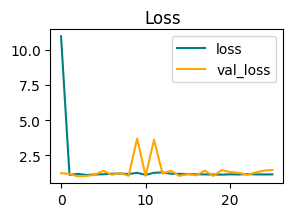

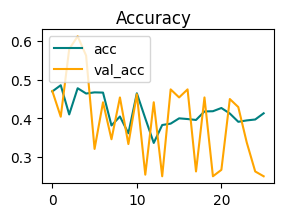

Fold Training Time: 2 hour(s) and 9 mins
Precision: 86.07594966888428  -  Recall: 28.333333134651184
Accuracy: 57.91666507720947
F1Score: Building 8.571428298950195 | Plant 83.9285659790039 | Road 60.5405387878418 | Vehicle 58.407081604003906
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/60758e22-79db-4289-a650-ca1dbebf5fa9
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 9.3763 - accuracy: 0.4792
Epoch 1: val_loss improved from inf to 1.26573, saving model to ./checkpoints/V4.1.1\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-7\assets


210/210 [==============================] - 315s 1s/step - loss: 9.3763 - accuracy: 0.4792 - val_loss: 1.2657 - val_accuracy: 0.4625 - lr: 0.0015
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.1196 - accuracy: 0.4905
Epoch 2: val_loss improved from 1.26573 to 1.11554, saving model to ./checkpoints/V4.1.1\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-7\assets


210/210 [==============================] - 308s 1s/step - loss: 1.1196 - accuracy: 0.4905 - val_loss: 1.1155 - val_accuracy: 0.5458 - lr: 0.0015
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 1.1121 - accuracy: 0.5256
Epoch 3: val_loss improved from 1.11554 to 0.89072, saving model to ./checkpoints/V4.1.1\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-7\assets


210/210 [==============================] - 308s 1s/step - loss: 1.1121 - accuracy: 0.5256 - val_loss: 0.8907 - val_accuracy: 0.5958 - lr: 0.0015
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 1.1095 - accuracy: 0.5107
Epoch 4: val_loss improved from 0.89072 to 0.84099, saving model to ./checkpoints/V4.1.1\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-7\assets


210/210 [==============================] - 308s 1s/step - loss: 1.1095 - accuracy: 0.5107 - val_loss: 0.8410 - val_accuracy: 0.6292 - lr: 0.0015
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 1.0070 - accuracy: 0.5518
Epoch 5: val_loss did not improve from 0.84099
210/210 [==============================] - 301s 1s/step - loss: 1.0070 - accuracy: 0.5518 - val_loss: 1.2989 - val_accuracy: 0.6625 - lr: 0.0015
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 1.0585 - accuracy: 0.5476
Epoch 6: val_loss did not improve from 0.84099
210/210 [==============================] - 302s 1s/step - loss: 1.0585 - accuracy: 0.5476 - val_loss: 2.3166 - val_accuracy: 0.3917 - lr: 0.0015
Epoch 7/45
210/210 [==============================] - ETA: 0s - loss: 1.0653 - accuracy: 0.5512
Epoch 7: val_loss improved from 0.84099 to 0.80525, saving model to ./checkpoints/V4.1.1\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.1\FOLD-7\assets


210/210 [==============================] - 310s 1s/step - loss: 1.0653 - accuracy: 0.5512 - val_loss: 0.8052 - val_accuracy: 0.6750 - lr: 0.0015
Epoch 8/45
210/210 [==============================] - ETA: 0s - loss: 1.0614 - accuracy: 0.5435
Epoch 8: val_loss did not improve from 0.80525
210/210 [==============================] - 301s 1s/step - loss: 1.0614 - accuracy: 0.5435 - val_loss: 1.4280 - val_accuracy: 0.5625 - lr: 0.0015
Epoch 9/45
210/210 [==============================] - ETA: 0s - loss: 1.0796 - accuracy: 0.5107
Epoch 9: val_loss did not improve from 0.80525
210/210 [==============================] - 301s 1s/step - loss: 1.0796 - accuracy: 0.5107 - val_loss: 0.9057 - val_accuracy: 0.6000 - lr: 0.0015
Epoch 10/45
210/210 [==============================] - ETA: 0s - loss: 1.1359 - accuracy: 0.4905
Epoch 10: val_loss did not improve from 0.80525
210/210 [==============================] - 303s 1s/step - loss: 1.1359 - accuracy: 0.4905 - val_loss: 1.2469 - val_accuracy: 0.3625 - 

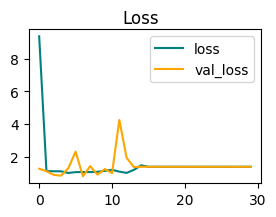

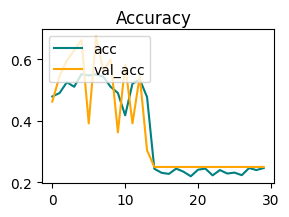

Fold Training Time: 2 hour(s) and 42 mins
Precision: 90.67796468734741  -  Recall: 44.583332538604736
Accuracy: 67.5000011920929
F1Score: Building 56.097557067871094 | Plant 81.81817626953125 | Road 78.0 | Vehicle 60.377357482910156
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
Total Training Time: 21 hour(s) and 56 mins


In [20]:
# ============================
# Log performance of each fold
# ============================

precisions = []
recalls = []
accuracies = []
f1_blds = []
f1_plants = []
f1_roads = []
f1_vhcls = []

counter = 0
start = perf_counter()
for train, test in kfold.split(train_x, train_y):
    start_fold = perf_counter()

    run = neptune.init_run(
        name= f"{model_name}-FOLD_{counter}",
        project=project_name,
        mode="offline"     # To prevent issue when internet sucks. Just manually sync it
    )  # your credentials

    run["parameters"] = params
    model = make_model(params)
    cat_y = tf.keras.utils.to_categorical(train_y)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], cat_y[train]))
    train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])
    
    test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], cat_y[test]))
    test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])
    
    hist = model.fit(train_fold, 
                     validation_data=test_fold,
                     batch_size=params['batch_size'],
                     epochs=params['epochs'],
                     verbose=1,
                     callbacks=create_callbacks(counter))
    end_fold = perf_counter()

    # PLOTTING ==================================================
    run["fig-train_loss"].upload(plot_loss(hist))
    run["fig-train_acc"].upload(plot_acc(hist))
    
    # EVALUATING ==================================================
    model = tf.keras.models.load_model(checkpoint_path + str(counter))
    
    pre = Precision()
    rec = Recall()
    c_acc = CategoricalAccuracy()
    f1_score = F1Score()
    for batch in test_fold.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X, verbose=0)
        f1_score.update_state(y, yhat)
        pre.update_state(y, yhat)
        rec.update_state(y, yhat)
        c_acc.update_state(y, yhat)
        
    precisions.append(pre.result().numpy() * 100)
    recalls.append(rec.result().numpy() * 100)
    accuracies.append(c_acc.result().numpy() * 100)
    f1_s = f1_score.result().numpy() * 100
    
    f1_blds.append(f1_s[0])
    f1_plants.append(f1_s[1])
    f1_roads.append(f1_s[2])
    f1_vhcls.append(f1_s[3])
    
    run["eval/ACC/"] = accuracies[counter]
    run["eval/REC/"] = recalls[counter]
    run["eval/PRE/"] = precisions[counter]
    run["eval/F1-Bld"] = f1_blds[counter]
    run["eval/F1-Plant"] = f1_plants[counter]
    run["eval/F1-Road"] = f1_roads[counter]
    run["eval/F1-Vhcl"] = f1_vhcls[counter]
    
    # PRINTING RESULTS ===========================================
    print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
    print(f'Precision: {precisions[counter]}  -  Recall: {recalls[counter]}')
    print(f'Accuracy: {accuracies[counter]}')
    print(f'F1Score: Building {f1_blds[counter]} | Plant {f1_plants[counter]} | Road {f1_roads[counter]} | Vehicle {f1_vhcls[counter]}')
    
    run.stop()
    
    counter += 1

end = perf_counter()

print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')

# Get Average Performance of Model

## Save to Neptune AI

In [21]:
run = neptune.init_run(
        name= f"{model_name}-AVG",
        project=project_name,
        mode='offline',
        # api_token=api_token, # Api token is saved in user's environemnt variables
    )  # your credentials

run["eval/PRE/"] = avg_rate(precisions)
run["eval/REC/"] = avg_rate(recalls)
run["eval/ACC/"] = avg_rate(accuracies)
run["eval/F1-Bld"] = avg_rate(f1_blds)
run["eval/F1-Plant"] = avg_rate(f1_plants)
run["eval/F1-Road"] = avg_rate(f1_roads)
run["eval/F1-Vhcl"] = avg_rate(f1_vhcls)

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: offline/7a7a328f-2e94-4176-a528-9646a55d6773
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


## Save to Tensorboard

In [22]:
# Command to access TensorBoard HParams:

# tensorboard --logdir PATH/logs/hparam_tuning
with tf.summary.create_file_writer(f'./logs/hparam_tuning/{model_name}').as_default():
    hparams = {
        'CONV_F1': 32,
        'CONV_F2': 32,
        'CONV_F3': 64,
        'CONV_F4': 64,
        'CONV_F5': 128,
        'CONV_F6': 128,
        'DROPOUT': 0.2,
        'D_UNITS_1': 128,
        'DROPOUT': 0.2,
        'D_UNITS_2': 128,
    }
    hp.hparams(hparams)
    tf.summary.scalar('PRE', avg_rate(precisions), step=1)
    tf.summary.scalar('REC', avg_rate(recalls), step=1)
    tf.summary.scalar('ACC', avg_rate(accuracies), step=1)
    tf.summary.scalar('F1 - Building', avg_rate(f1_blds), step=1)
    tf.summary.scalar('F1 - Plant', avg_rate(f1_plants), step=1)
    tf.summary.scalar('F1 - Road', avg_rate(f1_roads), step=1)
    tf.summary.scalar('F1 - Vehicle', avg_rate(f1_vhcls), step=1)

# Asd

# Others

In [ ]:
model= make_model()
model.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    callbacks=create_callbacks(0),
)

In [ ]:
true_test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
true_test_set = true_test_dataset.shuffle(buffer_size=true_test_dataset.cardinality(), seed=1).batch(64)

f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()
for batch in true_test_set.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_max = []
    for i in yhat:
        maxed = np.argmax(i)
        yhat_max.append(maxed)
    yhat = np.array(yhat_max)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)


In [ ]:
run["eval/ACC/"] = float(c_acc.result().numpy() * 100)
run["eval/REC/"] = float(rec.result().numpy() * 100)
run["eval/PRE/"] = float(pre.result().numpy() * 100)


In [ ]:
run.stop()

In [ ]:
eval_metrics = model.evaluate(x_test, y_test, verbose=0)
for j, metric in enumerate(eval_metrics):
    run["eval/AVG-ACC/{}".format(model.metrics_names[j])] = metric

run.stop()

In [ ]:
for j, metric in enumerate(eval_metrics):
    print(model.metrics_names[j])

## Neptune AI Notes